In [38]:
import theano
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

%matplotlib inline

The differential equations are

$$ \dfrac{dy}{dt} = f(y,t,p) $$
$$ \dfrac{d}{dt}\left( \dfrac{\partial y}{\partial p} \right) = \dfrac{\partial f }{\partial y} \dfrac{\partial y}{\partial p} + \dfrac{\partial f}{ \partial p} $$

In [39]:
def f(y, t, theta):
    """"This is the ODE system.
    
    The function can act on either numpy arrays or theano TensorVariables
    
    Args:
        y (vector): system state
        t (float): current time (optional)
        theta (vector): parameters of the ODEs
        
    Returns:
        dydt (list): result of the ODEs
    """
    return [
        -theta*y[0]*y[1],   #= dS/dt
        theta*y[0]*y[1] - y[1] #= dI/dt
            ]

In [40]:
#Initial Condition
np.random.seed(19920908)
Y0 = np.array([0.99,0.01, 0.0, 0.0])
#Space to compute solutions
t_dense = np.linspace(0,5,101)
#True param value
p_true = 8

In [54]:
#Define the differential Equation

#Present state of the system
y = tt.dvector('y')
#Parameter: Basic reproductive ratio
p = tt.dscalar('p')
#Present state of the gradients: will always be 0 unless the parameter is the inital condition
dydp = tt.dvector('dydp')

f_tensor = tt.stack(f(y, None, p))

#Now compute gradients
#Use Rop to compute the Jacobian vector product
Jdfdy = tt.Rop(f_tensor, y, dydp)

grad_f = tt.jacobian(f_tensor, p)
#This is the time derivative of dydp
ddt_dydp = Jdfdy + grad_f


#Compile the system as a theano function
#Args:
    #y - array of length 2 representing current state of the system (S and I)
    #dydp - array of length 2 representing current state of the gradient (dS/dp and dI/dp)
system = theano.function(
    inputs=[y, dydp, p],
    outputs=[f_tensor, ddt_dydp]
)

In [ ]:
#Tensor for observed data
t_y_obs = tt.dmatrix('y_obs')
#Tensor for predictions
t_y_pred = tt.dmatrix('y_pred')

#Define error and cost
t_err = t_y_obs - t_y_pred
Cost = 

In [60]:
#create a function to spit out derivatives
def ODESYS(Y,t,p):
    """
    Args:
        Y (vector): current state and gradient
        t (scalar): current time
        p (vector): parameters
        
    Returns:
        derivatives (vector): derivatives of state and gradient
    """
    dydt, dydp = system(Y[:2], Y[2:], p)
    return np.concatenate([dydt, dydp])

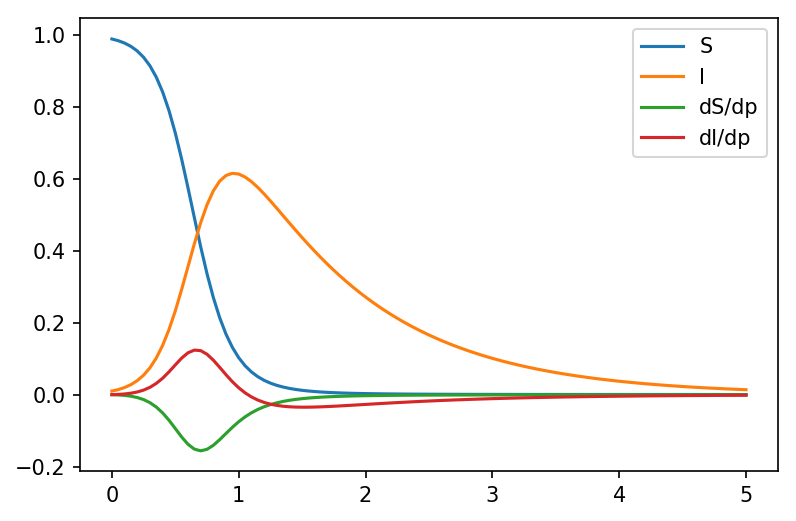

In [61]:
y_hat_theano = scipy.integrate.odeint(ODESYS, y0=Y0, t=t_dense, args=(p_true,))

plt.figure(dpi=150)
plt.plot(t_dense, y_hat_theano[:,0], label='S')
plt.plot(t_dense, y_hat_theano[:,1], label='I')
plt.plot(t_dense, y_hat_theano[:,2], label='dS/dp')
plt.plot(t_dense, y_hat_theano[:,3], label='dI/dp')
plt.legend()
plt.show()

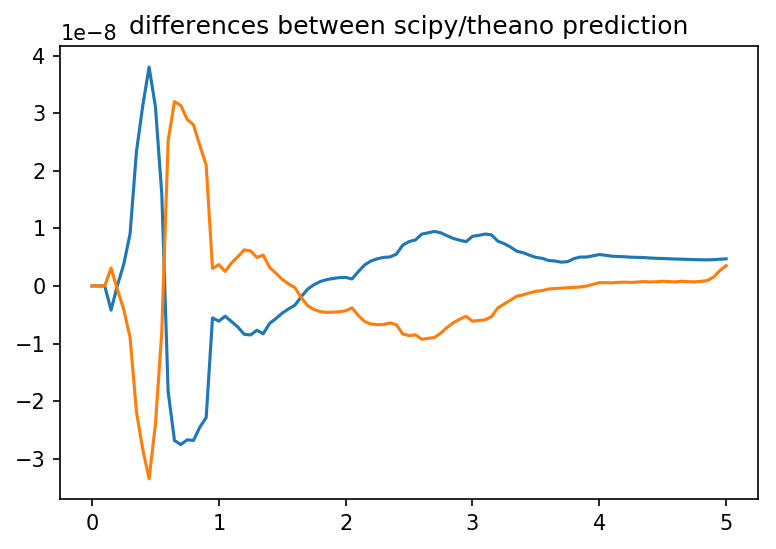

In [62]:
# use odeint without the forward sensitivity
y_hat_scipy = scipy.integrate.odeint(f, y0=Y0[:2], t=t_dense, args=(p_true,))

plt.figure(dpi=150)
plt.title('differences between scipy/theano prediction')
plt.plot(t_dense, y_hat_scipy[:,0] - y_hat_theano[:,0], label='$\delta S$')
plt.plot(t_dense, y_hat_scipy[:,1] - y_hat_theano[:,1], label='$\delta I$')
plt.show()

Here is what the gradients should look like:

$$ f = \begin{bmatrix} -pSI, pSI - I \end{bmatrix}$$

$$\dfrac{\partial f}{\partial y} = \begin{bmatrix} -pI & -pS \\ pI & pS - 1 \end{bmatrix}$$

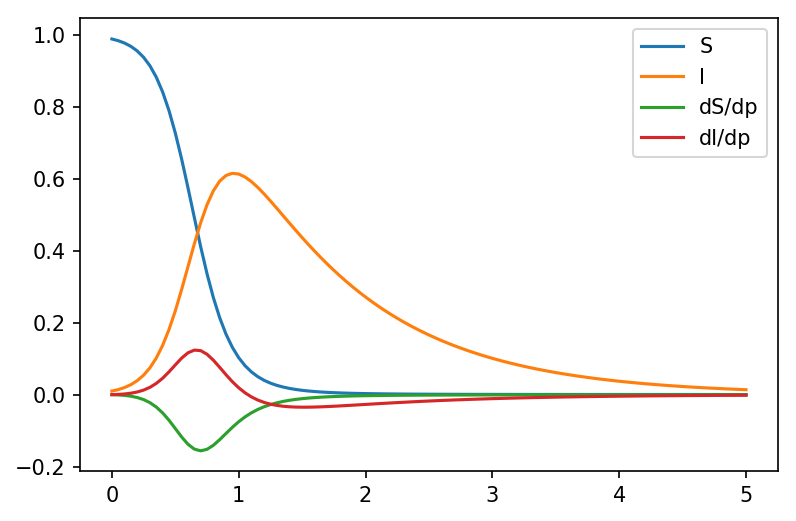

In [64]:
#What gradients should look like.

def analytical_J(y, p):
    """Analytical Jacobian"""
    s, i = y    
    j = np.array([
        [-p*i, -p*s],
        [p*i, p*s - 1]
    ])    
    return j

def analytical_grad_f(y,p):
    s,i = y
    return np.array([-s*i, s*i])


def analytical_sys(y,t,p):
    return np.concatenate([
        f(y[:2],y,p),
        np.dot(analytical_J(y[:2], p), y[2:]) + analytical_grad_f(y[:2],p)
    ])

y_hat_analytical = scipy.integrate.odeint(analytical_sys, y0=Y0, t=t_dense, args=(p_true,))

plt.figure(dpi=150)
plt.plot(t_dense, y_hat_analytical);
plt.legend(['S','I','dS/dp','dI/dp'])